In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://nu

In [2]:
x_train = pd.read_csv('data/s2e/audio_train.csv')
x_test = pd.read_csv('data/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(17052, 10)


In [3]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(17052, 10) (4264, 10)
{2: 5484, 5: 2739, 1: 2716, 0: 2267, 4: 2196, 3: 1650}


In [5]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:487: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/home/jls/repos/multimodal-speech-emotion-recognition/.env/python-3.7/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to 

Test Set Accuracy =  0.813
Test Set F-score =  0.826
Test Set Precision =  0.852
Test Set Recall =  0.814
Confusion matrix, without normalization
[[ 399   31   83    0    1   21]
 [  38  406  196    0    3   44]
 [  49   32 1258    0    4   37]
 [   0    0    0  427    0    0]
 [   0    0    0    0  532    0]
 [  24   28  201    3    1  446]]


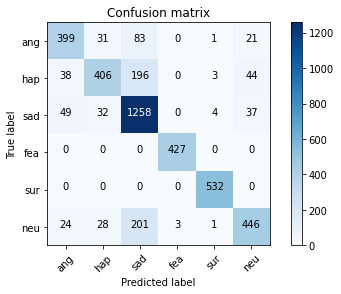

In [6]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [ ]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [ ]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [ ]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

In [ ]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [ ]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [ ]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

In [12]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.10141464, 0.13724172, 0.16135503, 0.12538774, 0.13871723,
       0.09987736, 0.10535656, 0.13064975], dtype=float32)

In [13]:
top_n = [3, 5, 6, 7, 8]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=1200, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 3 features:
Test Set Accuracy =  0.576
Test Set F-score =  0.566
Test Set Precision =  0.561
Test Set Recall =  0.574
Stats for top 5 features:
Test Set Accuracy =  0.581
Test Set F-score =  0.575
Test Set Precision =  0.572
Test Set Recall =  0.581
Stats for top 6 features:
Test Set Accuracy =  0.578
Test Set F-score =  0.581
Test Set Precision =  0.579
Test Set Recall =  0.584
Stats for top 7 features:
Test Set Accuracy =  0.596
Test Set F-score =  0.595
Test Set Precision =  0.593
Test Set Recall =  0.600
Stats for top 8 features:
Test Set Accuracy =  0.556
Test Set F-score =  0.556
Test Set Precision =  0.559
Test Set Recall =  0.559


Test Set Accuracy =  0.564
Test Set F-score =  0.550
Test Set Precision =  0.580
Test Set Recall =  0.562
Confusion matrix, without normalization
[[ 67  40  93   6   6  12]
 [ 34  48 175   1   3  39]
 [ 24  48 444   5  10  52]
 [  0   0   0 247   0   0]
 [  0   0   4   0 237   0]
 [ 12  20 263   0   8  62]]


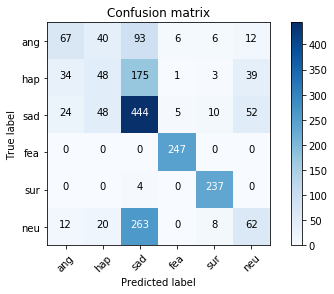

In [15]:
# Load predicted probabilities
# Load predicted probabilities
with open('pred_probas/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

with open('pred_probas/lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)